# Biodiversity Change in Phoenix, AZ (2017-2020)

This project repository can be found at: https://github.com/stephenccodes/biodiversity-intactness-index-phoenix

## <ins>About</ins>

### Purpose:

### Highlights:


### Data Description:
    
<ins>Microsoft Planetary Computer STAC catalog<\ins>

These datasets estimate terrestrial biodiversity intactness for the years 2017-2020 using 100-meter gridded maps. These maps serve as tools for helping to monitor global biodiversity and identify critical intact habitats. They combine biodiversity data with geospatial layers of human pressures to create high-resolution projections. They were generated by Impact Observatory in collaboration with Vizzuality. These maps are valuable for spatial planning, monitoring biodiversity, and identifying critical intact habitats.    

Date Accessed: 12/04/24

    
<ins>Arizona Counties <\ins>    

    
    
### **Reference List:**
    
1. Microsoft.com, “Microsoft Planetary Computer.”  2024, https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Access date: December 4, 2024.
    
2. [Arizona counties data](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=County+Subdivisions)

- United States Census Bureau. (2024). Arizona County Subdivision 2024 TIGER/Line Shapefiles. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Access date: December 4, 2024.

    
### Acknowledegements
All materials were created by [Carmen Galaz-Garcia](https://github.com/carmengg) for [EDS-220: Working with Environmental Data](https://meds-eds-220.github.io/MEDS-eds-220-course/).

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import Polygon

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

import contextily  as cx

In [ ]:
# Cell cleared to avoid pasting tokens, etc.
ee.Authenticate()



In [ ]:
ee.Initialize()

In [2]:
# Access io-biodiversity catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                      modifier=planetary_computer.sign_inplace,
    )

### Data exploration:

In [3]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [4]:
# Get the catalog collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


### Catalog exploration summary:
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [5]:
# Select the biodivesity collection
ib_collection = catalog.get_child('io-biodiversity')
ib_collection

<CollectionClient id=io-biodiversity>

In [6]:
# Phoenix bounding box in GeoJSON format
phx_bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],
            [-112.826843, 33.863574],
            [-111.184387, 33.863574],
            [-111.184387, 32.974108],
            [-112.826843, 32.974108]
        ]
    ],
}

# Temporal range of interest
time_range = "2017-01-01/2021-01-01"

# Catalog search for our parameters
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = phx_bbox,
    datetime = time_range)

In [7]:
# Retrieve the items that our search returned
items = search.item_collection()

# Determine how many items our search returned
len(items)

4

In [8]:
# Print out the assets for each item from our search
for i in range(len(items)):  # Loop over the list
    # Print a label for the each item
    print(f"Item {i + 1}: {items[i].id}") 
    # Loop across list
    for key in items[i].assets.keys():
        # Print the keys and title of the assets in each item
        print(f"  {key} -- {items[i].assets[key].title}")
    
    print()


Item 1: bii_2020_34.74464974521749_-115.38597824385106_cog
  data -- Biodiversity Intactness
  tilejson -- TileJSON with default rendering
  rendered_preview -- Rendered preview

Item 2: bii_2019_34.74464974521749_-115.38597824385106_cog
  data -- Biodiversity Intactness
  tilejson -- TileJSON with default rendering
  rendered_preview -- Rendered preview

Item 3: bii_2018_34.74464974521749_-115.38597824385106_cog
  data -- Biodiversity Intactness
  tilejson -- TileJSON with default rendering
  rendered_preview -- Rendered preview

Item 4: bii_2017_34.74464974521749_-115.38597824385106_cog
  data -- Biodiversity Intactness
  tilejson -- TileJSON with default rendering
  rendered_preview -- Rendered preview



In [9]:
# Select for years of interest, 2020 and 2017
item_2020 = items[0]
item_2017 = items[3]

In [10]:
# View the rendered preview of 2017
Image(url=item_2017.assets["rendered_preview"].href, width=500)

In [11]:
# View the rendered preview of 2020
Image(url=item_2020.assets["rendered_preview"].href, width=500)

## Collection exploration summary:

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


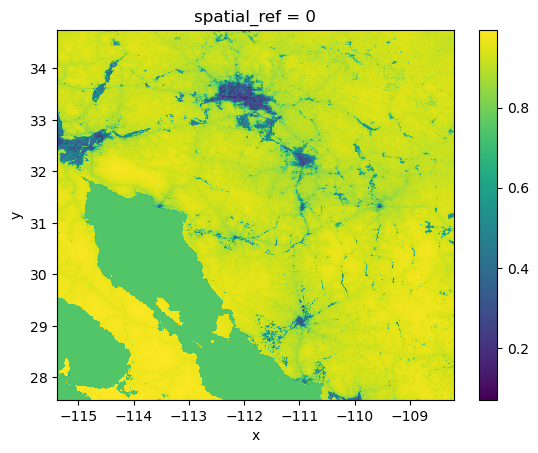

In [18]:
# Open the raster for 2017
rast_2017 = rioxr.open_rasterio(item_2017.assets["data"].href).squeeze().drop_vars("band")

# Drop the band 
rast_2017.plot()

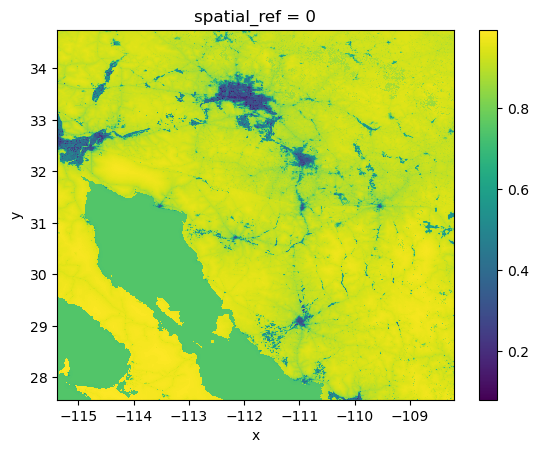

In [13]:
# Open the raster for 2020 and drop the band
rast_2020 = rioxr.open_rasterio(item_2020.assets["data"].href).squeeze().drop_vars("band")

rast_2020.plot()

## Read in Phoenix shapefile

In [14]:
# Establish a filepath to our Arizona geodata
fp = os.path.join('data/arizona_lines.zip')

# Read in the data
arizona = gpd.read_file(fp, zip = True)

<Axes: >

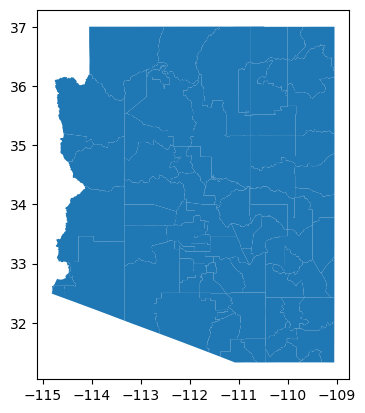

In [15]:
arizona.plot()

In [16]:
# Filter for Phoenix 
phx = arizona[arizona["NAME"]=="Phoenix"]

In [17]:
phx.borders.plot()

AttributeError: 'GeoDataFrame' object has no attribute 'borders'

In [26]:
# Define the landsat aspect ratio
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height 

# Initialize the figure and set the dimensions
fig, ax = plt.subplots(figsize = (9, 5 * landsat_aspect_ratio)) # Apply the aspect ratio

# Set the background color of the entire figure 
fig.patch.set_facecolor('beige')

# Remove axes for cleaner map
ax.axis('off') 

# Plot the false color remorte sensing data
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax)

# Plot the Thomas Fire perimeter
thomas_fire.boundary.plot(ax = ax, 
                          color = "red", # Color it red for emphasis
                          linewidth = 0.8)

# Add a main title
ax.set_title("The 2017 Thomas Fire Scar\n", fontsize = 12)

# Add subtitle describing the false colors
fig.suptitle("False Colors with Short Wave Infrared, Near-Infrared, & Red Wavelengths", 
             color = 'black', 
             fontsize = 10, 
             fontweight='light', 
             y=0.91)

# Add a legend for the fire boundary
ax.legend(labels = ['Thomas Fire (2017) Scar'])

# Add a footnote citation at the bottom of the figure
fig.text(0.379, 0.1, # Position
         'Data Source: CAL FIRE & USGS EROS Archive',
         ha='center', # Horizontal alignment
         va='center', # Vertical alignment
         fontsize=8, 
         color='black', 
         fontstyle='italic')
fig.text(0.395, 0.08, # Position 
         'Date Accessed: 11/19/24',
         ha='right', # Horizontal alignment
         va='center', # Vertical alignment
         fontsize=8, 
         color='black', 
         fontstyle='italic')

plt.show()

NameError: name 'landsat' is not defined

In [28]:
zaragoza = phx.query("city_id == 'ci122'")
ax = zaragoza.plot(facecolor="none",
                   edgecolor="red",
                   linewidth=2
                  )
cx.add_basemap(ax,
               crs=zaragoza.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

UndefinedVariableError: name 'city_id' is not defined